In [1]:
from math import log
import matplotlib.pyplot as plt
from math import log, exp
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.callbacks import History
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers.recurrent import GRU
from keras.layers.advanced_activations import ELU
from keras import initializers
from collections import deque
import random
import copy
import datetime as dt
from matplotlib import style
import pandas as pd
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
class Param:
    K = 5
    M = 10
    pSize = 1000
    tickSize = 0.001
    lotSize = 100
    pe = 50
    sigma = 0.1
    lam = log(2)/5
    kappa = 10**(-14)
    nTrain = 10**4
    epsilon = 0.1
    alpha = 0.01
    gamma = 0.99
    capital = 50000

In [3]:
class ActionSpace:
    def create(self):
        actions = []
        for i in range(-1*Param.K, Param.K + 1):
            actions.append(i*Param.lotSize)
        return actions

In [4]:
class Cost(object):
    def getSpreadCost(self, dn):
        return Param.tickSize * abs(dn)
    
    def getImpactCost(self, dn):
        #return dn ** 2 * Param.tickSize/Param.lotSize
        return 0
    
    def getTotalCost(self, dn):
        return self.getSpreadCost(dn) + self.getImpactCost(dn)
    
if __name__ == '__main__':
    print(Param.tickSize)
    print(Cost().getTotalCost(400))

0.001
0.4


In [5]:
class HoldingSpace:
    hold = []
    def create(self):
        for i in range(-1*Param.M, Param.M+1):
            self.hold.append(i * Param.lotSize)
        return self.hold
    
    def getMax():
        return Param.M*Param.lotSize
    
    def getMin():
        return -1*Param.M*Param.lotSize

if __name__ == '__main__':
    print(HoldingSpace.getMax())

1000


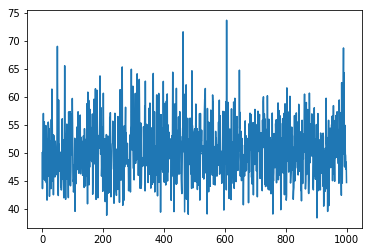

In [6]:
class PriceSampler(object):
    def genPrice(self, size):
        price = []
        pe = Param.pe
        sigma = Param.sigma
        lam = Param.lam
        
        price.append(pe)
        for i in range(size):
            y = log(pe/pe)
            y += - lam * y + sigma * np.random.normal()
            pnew = pe * exp(y)
            price.append(pnew)
        return price
    
    def main(self):
        samples = self.genPrice(1000)
        plt.plot(samples)
        plt.show()
        
if __name__ == '__main__':
    PriceSampler().main()
        

In [7]:
class PriceSpace(object):
    def create(self):
        L = []
        for i in range(Param.pSize):
            L.append(round(Param.tickSize*i, 1))
        return L

In [8]:
class State(object):
    def __init__(self, price_changes, price, hold):
        self.price_changes = price_changes
        self.price = price
        self.hold = hold
        
    def tolist(self):
        nprice = list(self.price_changes)
        nprice.append(self.price)
        nprice.append(self.hold)
        return nprice

In [9]:
class Result:
    def __init__(self, currState, nextState):
        self.currState = currState
        self.nextState = nextState
        
    def getReward(self):
        pnl = self.getPnl()
        reward = pnl - 0.5 * Param.kappa * pnl**2
        return reward
    
    def getReturn(self, capital):
        reward = self.getReward()
        rt = reward/capital
        return rt
    
    def getPnl(self):
        currHolding = self.currState.hold
        nextHolding = self.nextState.hold
        currPrice = self.currState.price
        nextPrice = self.nextState.price
        
        dn = nextHolding - currHolding
        cost = Cost().getTotalCost(dn)
        pnl = nextHolding * (nextPrice - currPrice) - cost
        return pnl

In [10]:
class DeepQnet:
    actionSpace = ActionSpace().create()
    def build_model(self):
        model = Sequential()
        model.add(GRU(64, input_shape=(1,7), return_sequences=True))
        model.add(GRU(32, return_sequences=True))
        model.add(GRU(16))
        #model.add(Dense(200, activation='relu'))
        #model.add(Dense(200, activation='relu'))
        #model.add(GRU(400, return_sequences=True))
        model.add(Dense(32, activation=ELU()))
        model.add(Dense(len(self.actionSpace), activation='linear'))
        model.compile(loss='mse', optimizer=optimizers.Adam(lr=0.001), metrics = ['accuracy'])
        return model

/Users/IVAN/anaconda3/lib/python3.5/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as ELU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


100
200
300
400
500
600
700
800
900
1000


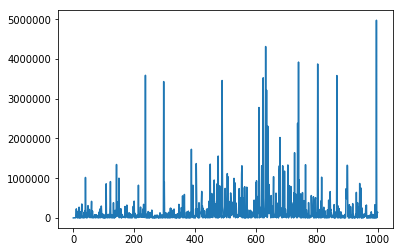

In [15]:
class QLearner:
    maxHold = HoldingSpace.getMax()
    minHold = HoldingSpace.getMin()
    
    actionSpace = ActionSpace().create()
    model = DeepQnet().build_model()
    memory = deque(maxlen = 20)
    batch_size = 10
    
    def qLearning(self):
        curr_price_changes = deque(maxlen=5)
        losses = []
        currHolding = 0
        #pricePath = PriceSampler().genPrice(5*Param.nTrain)
        pricePath = train
        for i in range(1, len(pricePath)-1):
            #see the price update but havent take action yet
            curr_price_changes.append(pricePath[i] - pricePath[i-1])
            if i < 5:
                continue
            currState = State(curr_price_changes, pricePath[i], currHolding)
            #choose action
            action_index = np.argmax(self.model.predict(np.reshape(currState.tolist(), [1,1,7])))
            shares_traded = self.actionSpace[action_index]
            
            #action to the next state
            nextHolding = max(min(currHolding + shares_traded, self.maxHold), self.minHold)
            next_price_changes = copy.copy(curr_price_changes)
            next_price_changes.append(pricePath[i+1] - pricePath[i])
            nextState = State(next_price_changes, pricePath[i+1], nextHolding)
            
            #observe reward
            reward = Result(currState, nextState).getReward()
            self.memory.append((currState, action_index, reward, nextState))
            currState = np.reshape(currState.tolist(), [1,1,7])
            nextState = np.reshape(nextState.tolist(), [1,1,7])
            target = reward + Param.gamma * np.amax(self.model.predict(nextState)[0])
            target_f = self.model.predict(currState)
            target_f[0][action_index] = target
            history = self.model.fit(currState, target_f, epochs = 1, verbose = 0)
            losses.append(history.history['loss'][-1])
            currHolding = nextHolding
#             if((i-198)%128 == 0 and i > 498):
#                 minibatch = random.sample(self.memory, self.batch_size)
#                 for currState, action_index, reward, nextState in minibatch:
#                     #update Q matrix
#                     currState = np.reshape(currState.tolist(), [1,1,200])
#                     nextState = np.reshape(nextState.tolist(), [1,1,200])
#                     target = reward + Param.gamma*np.amax(self.model.predict(nextState)[0])
            if i%100 == 0: print(i)
        plt.plot(losses)
        return self.model
    
    def run(self, model):
        capital = Param.capital
        curr_price_changes = deque(maxlen=5)
        losses = []
        ret = []
        currHolding = 0
        pricePath = test
        for i in range(1, len(pricePath)-1):
            #see the price update but havent take action yet
            curr_price_changes.append(pricePath[i] - pricePath[i-1])
            if i < 5:
                continue
            currState = State(curr_price_changes, pricePath[i], currHolding)
            #choose action
            action_index = np.argmax(model.predict(np.reshape(currState.tolist(), [1,1,7])))
            shares_traded = self.actionSpace[action_index]
            
            #action to the next state
            nextHolding = max(min(currHolding + shares_traded, self.maxHold), self.minHold)
            next_price_changes = copy.copy(curr_price_changes)
            next_price_changes.append(pricePath[i+1] - pricePath[i])
            nextState = State(next_price_changes, pricePath[i+1], nextHolding)
            
            #observe reward
            reward = Result(currState, nextState).getReward()
            capital += reward
            rt = Result(currState, nextState).getReturn(capital)
            currHolding = nextHolding
            ret.append(rt)
        return ret

if __name__ == '__main__':
    df = pd.read_csv('stocks/AAPL_data.csv')
    end = int(0.8*len(df))
    train, test = df['close'][:end].reset_index(drop=True), df['close'][end:].reset_index(drop=True)
    model = QLearner().qLearning()
    ret = QLearner().run(model)

Text(0.5,1,'Daily Return')

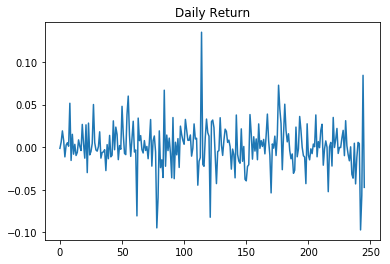

In [21]:
plt.plot(ret)
plt.title('Daily Return')

In [24]:
df = pd.DataFrame(ret)

In [28]:
df[0].autocorr(lag=5)

0.09708061201114535

In [29]:
df[0].std() * 252**(0.5)

0.4201863347528484

In [30]:
mulvar = 252*df[0].var()*(1 + 2*sum([(1 - i/252) * df[0].autocorr(lag=i) for i in range(1, 6)]))
print(mulvar**(0.5))

0.46551436843149047


In [31]:
sharpe = ((df[0].mean()+1)**252-1)/(df[0].std()*252**(1/2))
print(sharpe)

0.8761560145563383


In [32]:
print('Sharpe after serial: ', ((df[0].mean()+1)**252-1)/((mulvar)**(0.5)))

Sharpe after serial:  0.7908430102137037


In [33]:
print('Sortino: ', ((df[0].mean()+1)**252-1)/(252*sum(df[0].apply(lambda x: min(x, 0)**2))/len(df[0]))**(0.5))

Sortino:  1.2805873017632767


In [34]:
import numpy as np
def maxdrawdown(arr):
    i = np.argmax((np.maximum.accumulate(arr) - arr)/np.maximum.accumulate(arr)) # end of the period
    j = np.argmax(arr[:i]) # start of period
    return (1-arr[i]/arr[j])

In [35]:
def maxdd(arr):
    maxim = arr.max()
    y = arr.apply(lambda x: abs(min(0, (x-maxim)/maxim)))
    return y.max()

In [36]:
print('Calmar:', ((df[0].mean()+1)**252-1)/maxdrawdown(df[0]))

Calmar: 0.1427963131251976


/Users/IVAN/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


In [37]:
def omega_ratio(returns, risk_free=0.0, required_return=0.0,
                annualization=252):

    if len(returns) < 2:
        return np.nan

    if annualization == 1:
        return_threshold = required_return
    elif required_return <= -1:
        return np.nan
    else:
        return_threshold = (1 + required_return) ** \
            (1. / annualization) - 1

    returns_less_thresh = returns - risk_free - return_threshold

    numer = sum(returns_less_thresh[returns_less_thresh > 0.0])
    denom = -1.0 * sum(returns_less_thresh[returns_less_thresh < 0.0])

    if denom > 0.0:
        return numer / denom
    else:
        return np.nan

In [38]:
omega_ratio(df[0])

1.1448006194498928

In [39]:
import scipy.stats as stats

In [40]:
stats.skew(df[0])

0.08211753470316473

In [41]:
stats.kurtosis(df[0])

3.9999110716661166